In [1]:
%cd ..

/Users/pavanpreetgandhi/git-repos/interpretable-sla


In [2]:
import numpy as np
import pandas as pd

from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

from sklearn.linear_model import LinearRegression, RidgeCV, ElasticNetCV
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from xgboost import XGBRegressor
from sklearn.neural_network import MLPRegressor

from sklearn.model_selection import GridSearchCV
from skopt import BayesSearchCV
from skopt.space import Real, Integer, Categorical

from source.fit_predict_score_utils import fit_and_predict, build_score_df, calibrate_score_df, plot_score_df, compute_metrics

In [3]:
df = pd.read_parquet("datasets/1_original_question_set.parquet")
features = df.columns[5:]
df[features] = np.exp(df[features])  # convert logprobs to probabilities
display(df)

,speaker_id,subset,part,part_score,overall_score,pronunciation_and_fluency_1_high,pronunciation_and_fluency_1_medium,pronunciation_and_fluency_1_low,pronunciation_and_fluency_2_high,pronunciation_and_fluency_2_medium,...,discourse_management_1_low,discourse_management_2_high,discourse_management_2_medium,discourse_management_2_low,discourse_management_3_high,discourse_management_3_medium,discourse_management_3_low,discourse_management_4_high,discourse_management_4_medium,discourse_management_4_low
file_id,,,,,,,,,,,,,,,,,,,,,
SI114J-00001-P40018,SI114J-00001,train,4,3.0,NaN,0.299412,0.633854,0.055386,0.294479,0.428464,...,0.214977,0.214231,0.582340,0.189058,0.229732,0.551099,0.202738,0.262142,0.554954,0.169251
SI114J-00002-P10003,SI114J-00002,train,1,4.5,NaN,0.375223,0.581157,0.032787,0.405843,0.459881,...,0.067658,0.229838,0.586911,0.168153,0.230740,0.667667,0.084884,0.299387,0.595403,0.091308
SI114J-00002-P10004,SI114J-00002,train,1,4.5,NaN,0.371740,0.575762,0.041708,0.421955,0.396390,...,0.095372,0.224143,0.537692,0.224143,0.246434,0.629291,0.109354,0.290313,0.542376,0.155393
SI114J-00002-P10005,SI114J-00002,train,1,4.5,NaN,0.546287,0.425449,0.019899,0.529330,0.363803,...,0.028431,0.368825,0.536637,0.082296,0.297272,0.591196,0.096510,0.441974,0.500822,0.046584
SI114J-00002-P10006,SI114J-00002,train,1,4.5,NaN,0.368509,0.607569,0.016191,0.373764,0.543824,...,0.034270,0.179180,0.708671,0.102094,0.258163,0.659243,0.069484,0.280468,0.672809,0.037957
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
SI137O-01032-P50019,SI137O-01032,eval,5,3.5,3.25,0.429821,0.518464,0.039980,0.466936,0.363650,...,0.078821,0.272289,0.576437,0.136916,0.225194,0.612141,0.145396,0.391508,0.502706,0.092991
SI137O-01032-P50020,SI137O-01032,eval,5,3.5,3.25,0.477393,0.477393,0.034582,0.432385,0.358460,...,0.132971,0.261948,0.554543,0.169126,0.220886,0.600430,0.161604,0.383218,0.462249,0.140978
SI137O-01032-P50021,SI137O-01032,eval,5,3.5,3.25,0.390685,0.534003,0.063778,0.393036,0.393036,...,0.134414,0.326988,0.539113,0.120292,0.225635,0.613341,0.145681,0.365757,0.469641,0.152470


In [4]:
experiments = [
    {
        "name": "Linear Regression",
        "dataset": df,
        "features": features,
        "pipeline": Pipeline([
            ("scaler", StandardScaler()),
            ("model", LinearRegression())
        ]),
    },
    {
        "name": "Ridge Regression",
        "dataset": df,
        "features": features,
        "pipeline": Pipeline([
            ("scaler", StandardScaler()),
            ("model", RidgeCV(
                alphas=np.logspace(-5, 2, 20)
            ))
        ]),
    },
    {
        "name": "ElasticNet Regression",
        "dataset": df,
        "features": features,
        "pipeline": Pipeline([
            ("scaler", StandardScaler()),
            ("model", ElasticNetCV(
                alphas=np.logspace(-5, 2, 20),
                l1_ratio=[0.01, 0.1, 0.5, 0.9, 0.99],
                max_iter=100_000,
                tol=1e-3
            ))
        ]),
    },
    {
        "name": "KNN Regression",
        "dataset": df,
        "features": features,
        "pipeline": Pipeline([
            ("scaler", StandardScaler()),
            ("model", GridSearchCV(
                KNeighborsRegressor(),
                param_grid={
                    'n_neighbors': [3, 5, 7, 10, 15, 20, 25, 30, 35, 40, 45, 50],
                    'weights': ['uniform', 'distance'],
                    'metric': ['euclidean', 'manhattan']
                },
                cv=5,
                n_jobs=-1
            ))
        ]),
    },
    {
        "name": "Support Vector Regression",
        "dataset": df,
        "features": features,
        "pipeline": Pipeline([
            ("scaler", StandardScaler()),
            ("model", BayesSearchCV(
                SVR(),
                search_spaces={
                    'C': Real(0.1, 100, prior='log-uniform'),
                    'epsilon': Real(0.01, 1, prior='log-uniform'),
                    'kernel': Categorical(['linear', 'rbf']),
                    'gamma': Real(0.005, 1, prior='log-uniform')
                },
                cv=5,
                n_jobs=-1,
                n_iter=30,
                verbose=3
            ))
        ]),
    },
    {
        "name": "XGBoost Regression",
        "dataset": df,
        "features": features,
        "pipeline": Pipeline([
            ("scaler", StandardScaler()),
            ("model", BayesSearchCV(
                XGBRegressor(objective='reg:squarederror', random_state=42),
                search_spaces={
                    'n_estimators': Integer(100, 1000),
                    'max_depth': Integer(3, 10),
                    'learning_rate': Real(0.01, 0.3, prior='log-uniform'),
                    'subsample': Real(0.6, 1.0, prior='uniform'),
                    'colsample_bytree': Real(0.6, 1.0, prior='uniform'),
                    'gamma': Real(0, 0.5, prior='uniform'),
                    'reg_alpha': Real(1e-9, 1.0, prior='log-uniform'),
                    'reg_lambda': Real(1e-9, 1.0, prior='log-uniform'),
                },
                cv=5,
                n_jobs=-1,
                n_iter=30,
                verbose=3
            ))
        ]),
    },
    {
        "name": "MLP Regression",
        "dataset": df,
        "features": features,
        "pipeline": Pipeline([
            ("scaler", StandardScaler()),
            ("model", GridSearchCV(
                MLPRegressor(max_iter=2000, random_state=42, early_stopping=True, validation_fraction=0.1),
                param_grid={
                    'hidden_layer_sizes': [
                        (64,), (128,), (256,), (512,), # Single layer
                        (64, 32), (128, 64), (256, 128), (512, 256), # Two layers - decreasing
                        (128, 128), (256, 256), (512, 512), # Two layers - same size
                        (128, 64, 32), (256, 128, 64), (512, 256, 128) # Three layers
                    ],
                    'activation': ['relu'],
                    'alpha': [5e-5, 1e-4, 5e-4, 1e-3, 5e-3],  # Reduced to 2
                    'learning_rate_init': [1e-3],  # Fixed to 1 value
                    'learning_rate': ['adaptive'],  # Fixed to 1 value
                },
                cv=5,
                n_jobs=-1,
                verbose=3
            ))
        ])
    }
]

In [5]:
PARTS = ["part_1", "part_3", "part_4", "part_5", "overall"]
SUBSETS = ["train", "dev", "eval"]
metrics_all = {f"{subset}_{part}": {} for subset in SUBSETS for part in PARTS}
score_dfs = {}
calibrated_score_dfs = {}
for experiment in experiments:
    print(f"\nRunning experiment: {experiment['name']}")
    predictions, pipelines = fit_and_predict(
        df=experiment["dataset"],
        features=experiment["features"],
        pipeline=experiment["pipeline"],
    )
    score_df = build_score_df(
        df=experiment["dataset"],
        predictions=predictions,
    )
    calibrated_score_df = calibrate_score_df(
        score_df,
        calibration_set='dev'
    )
    metrics = compute_metrics(
        score_df=calibrated_score_df,
        n_bootstraps=1000,
        subsets=["train", "dev", "eval"],
    )
    score_dfs[experiment["name"]] = score_df
    calibrated_score_dfs[experiment["name"]] = calibrated_score_df
    for subset in SUBSETS:
        for part in PARTS:
            metrics_all[f"{subset}_{part}"][experiment["name"]] = metrics[subset][part]
    
    for part, pipeline in pipelines.items():
        model = pipeline.named_steps['model']
        print(f"{experiment['name']} - Part {part}: ", end="")
        
        # Print specific best parameters for CV models
        params = []
        if hasattr(model, 'alpha_'):
            params.append(f"alpha: {model.alpha_}")
        if hasattr(model, 'l1_ratio_'):
            params.append(f"l1_ratio: {model.l1_ratio_}")
        if hasattr(model, 'best_params_'):  # For GridSearchCV
            params.append(f"best_params: {model.best_params_}")
        
        if params:
            print(", ".join(params))
        else:
            print("No hyperparameters to display")


Running experiment: Linear Regression
Linear Regression - Part 1: No hyperparameters to display
Linear Regression - Part 3: No hyperparameters to display
Linear Regression - Part 4: No hyperparameters to display
Linear Regression - Part 5: No hyperparameters to display

Running experiment: Ridge Regression
Ridge Regression - Part 1: alpha: 0.008858667904100823
Ridge Regression - Part 3: alpha: 0.00379269019073225
Ridge Regression - Part 4: alpha: 0.001623776739188721
Ridge Regression - Part 5: alpha: 0.008858667904100823

Running experiment: ElasticNet Regression


/Users/pavanpreetgandhi/git-repos/interpretable-sla/.venv/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.892e+02, tolerance: 7.434e+00
  model = cd_fast.enet_coordinate_descent_gram(
/Users/pavanpreetgandhi/git-repos/interpretable-sla/.venv/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.434e+03, tolerance: 7.434e+00
  model = cd_fast.enet_coordinate_descent_gram(
/Users/pavanpreetgandhi/git-repos/interpretable-sla/.venv/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want

ElasticNet Regression - Part 1: alpha: 1e-05, l1_ratio: 0.99
ElasticNet Regression - Part 3: alpha: 1e-05, l1_ratio: 0.99
ElasticNet Regression - Part 4: alpha: 1e-05, l1_ratio: 0.9
ElasticNet Regression - Part 5: alpha: 1e-05, l1_ratio: 0.99

Running experiment: KNN Regression
KNN Regression - Part 1: best_params: {'metric': 'euclidean', 'n_neighbors': 45, 'weights': 'distance'}
KNN Regression - Part 3: best_params: {'metric': 'manhattan', 'n_neighbors': 30, 'weights': 'distance'}
KNN Regression - Part 4: best_params: {'metric': 'manhattan', 'n_neighbors': 35, 'weights': 'distance'}
KNN Regression - Part 5: best_params: {'metric': 'manhattan', 'n_neighbors': 50, 'weights': 'distance'}

Running experiment: Support Vector Regression
Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV 1/5] END C=3.1969228790203426, epsilon=0.48935590267119916, gamma=0.013574903172061592, kernel=rbf;, score=0.214 total time=   6.5s
[CV 2/5] END C=3.1969228790203426, epsilon=0.48935590267119916,

/Users/pavanpreetgandhi/git-repos/interpretable-sla/source/fit_predict_score_utils.py:38: FutureWarning: The behavior of array concatenation with empty entries is deprecated. In a future version, this will no longer exclude empty items when determining the result dtype. To retain the old behavior, exclude the empty entries before the concat operation.
  predictions = pd.concat([predictions, pd.Series(y_all_pred, index=df_part.index)])


Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV 2/5] END colsample_bytree=0.9334438612577266, gamma=0.09683804104987695, learning_rate=0.06000045858367513, max_depth=4, n_estimators=709, reg_alpha=2.0111987025034125e-06, reg_lambda=0.11075670072994709, subsample=0.7966752071960319;, score=0.340 total time=   0.9s
[CV 3/5] END colsample_bytree=0.9334438612577266, gamma=0.09683804104987695, learning_rate=0.06000045858367513, max_depth=4, n_estimators=709, reg_alpha=2.0111987025034125e-06, reg_lambda=0.11075670072994709, subsample=0.7966752071960319;, score=0.390 total time=   0.9s
[CV 4/5] END colsample_bytree=0.9334438612577266, gamma=0.09683804104987695, learning_rate=0.06000045858367513, max_depth=4, n_estimators=709, reg_alpha=2.0111987025034125e-06, reg_lambda=0.11075670072994709, subsample=0.7966752071960319;, score=0.432 total time=   0.9s
[CV 5/5] END colsample_bytree=0.9334438612577266, gamma=0.09683804104987695, learning_rate=0.06000045858367513, max_depth=4, n_e

In [6]:
for category, metrics in metrics_all.items():
    print(f"{category}")
    metrics_df = pd.DataFrame(metrics).T.map(lambda x: f"{x[0]:.4f} ± {x[1]:.4f}")
    display(metrics_df)

train_part_1


,rmse,pcc,src,p05,p1
Linear Regression,0.5274 ± 0.0066,0.7054 ± 0.0089,0.6978 ± 0.0098,64.6562 ± 0.8623,93.9720 ± 0.4139
Ridge Regression,0.5272 ± 0.0066,0.7057 ± 0.0089,0.6981 ± 0.0098,64.5877 ± 0.8624,93.9740 ± 0.4143
ElasticNet Regression,0.5263 ± 0.0066,0.7067 ± 0.0089,0.6991 ± 0.0098,64.3623 ± 0.8588,94.0722 ± 0.4143
KNN Regression,1.1187 ± 0.0138,1.0000 ± 0.0000,0.9780 ± 0.0007,26.2643 ± 0.7911,70.8710 ± 0.8219
Support Vector Regression,0.4827 ± 0.0061,0.7588 ± 0.0078,0.7444 ± 0.0088,70.1472 ± 0.7965,96.2921 ± 0.3330
XGBoost Regression,0.4018 ± 0.0051,0.8453 ± 0.0053,0.8279 ± 0.0065,79.4401 ± 0.7097,98.6322 ± 0.2064
MLP Regression,0.4855 ± 0.0061,0.7561 ± 0.0078,0.7431 ± 0.0088,69.5457 ± 0.8251,95.9975 ± 0.3437


train_part_3


,rmse,pcc,src,p05,p1
Linear Regression,0.5173 ± 0.0068,0.6756 ± 0.0104,0.6573 ± 0.0111,67.1350 ± 0.8505,94.8450 ± 0.3947
Ridge Regression,0.5174 ± 0.0068,0.6755 ± 0.0104,0.6573 ± 0.0111,67.2627 ± 0.8454,94.9409 ± 0.3915
ElasticNet Regression,0.5177 ± 0.0068,0.6750 ± 0.0105,0.6573 ± 0.0111,67.0412 ± 0.8461,94.9416 ± 0.3931
KNN Regression,0.0847 ± 0.0006,1.0000 ± 0.0000,1.0000 ± 0.0000,100.0000 ± 0.0000,100.0000 ± 0.0000
Support Vector Regression,0.5178 ± 0.0069,0.6744 ± 0.0106,0.6575 ± 0.0111,67.4750 ± 0.8506,94.9075 ± 0.3939
XGBoost Regression,0.3487 ± 0.0044,0.8916 ± 0.0037,0.8807 ± 0.0046,84.6012 ± 0.6543,99.6066 ± 0.1135
MLP Regression,0.4747 ± 0.0060,0.7427 ± 0.0083,0.7216 ± 0.0094,70.1666 ± 0.8339,97.0693 ± 0.3198


train_part_4


,rmse,pcc,src,p05,p1
Linear Regression,0.5524 ± 0.0070,0.6860 ± 0.0094,0.6775 ± 0.0103,63.0600 ± 0.8926,93.0777 ± 0.4565
Ridge Regression,0.5525 ± 0.0070,0.6859 ± 0.0094,0.6776 ± 0.0103,62.8927 ± 0.8952,93.0456 ± 0.4585
ElasticNet Regression,0.5534 ± 0.0069,0.6848 ± 0.0094,0.6771 ± 0.0104,62.9654 ± 0.8917,93.1839 ± 0.4520
KNN Regression,0.0846 ± 0.0009,1.0000 ± 0.0000,1.0000 ± 0.0000,100.0000 ± 0.0000,100.0000 ± 0.0000
Support Vector Regression,0.5546 ± 0.0070,0.6834 ± 0.0095,0.6755 ± 0.0105,63.0813 ± 0.8971,92.9453 ± 0.4669
XGBoost Regression,0.4949 ± 0.0063,0.7706 ± 0.0072,0.7507 ± 0.0086,68.4444 ± 0.8515,95.9153 ± 0.3684
MLP Regression,0.5519 ± 0.0070,0.6932 ± 0.0090,0.6839 ± 0.0098,63.0654 ± 0.9174,93.1711 ± 0.4590


train_part_5


,rmse,pcc,src,p05,p1
Linear Regression,0.4898 ± 0.0070,0.7292 ± 0.0090,0.7202 ± 0.0099,69.1453 ± 0.8398,95.8487 ± 0.3830
Ridge Regression,0.4897 ± 0.0070,0.7292 ± 0.0090,0.7203 ± 0.0099,69.0830 ± 0.8432,95.7820 ± 0.3868
ElasticNet Regression,0.4897 ± 0.0070,0.7291 ± 0.0090,0.7201 ± 0.0098,69.1479 ± 0.8509,95.8176 ± 0.3855
KNN Regression,0.7802 ± 0.0098,1.0000 ± 0.0000,1.0000 ± 0.0000,25.9688 ± 0.7759,73.5863 ± 0.8088
Support Vector Regression,0.4905 ± 0.0070,0.7278 ± 0.0090,0.7191 ± 0.0098,69.2399 ± 0.8339,95.7549 ± 0.3884
XGBoost Regression,0.3549 ± 0.0049,0.8722 ± 0.0045,0.8628 ± 0.0052,84.3922 ± 0.6607,99.2438 ± 0.1564
MLP Regression,0.4400 ± 0.0060,0.7893 ± 0.0070,0.7730 ± 0.0082,74.7224 ± 0.8119,97.4934 ± 0.2871


train_overall


,rmse,pcc,src,p05,p1
Linear Regression,0.4200 ± 0.0081,0.7640 ± 0.0103,0.7630 ± 0.0116,78.7502 ± 1.0011,97.7460 ± 0.3515
Ridge Regression,0.4202 ± 0.0081,0.7638 ± 0.0103,0.7629 ± 0.0116,78.7501 ± 0.9993,97.8037 ± 0.3478
ElasticNet Regression,0.4207 ± 0.0081,0.7631 ± 0.0104,0.7620 ± 0.0117,78.6297 ± 0.9963,97.7474 ± 0.3518
KNN Regression,0.7490 ± 0.0149,0.9599 ± 0.0027,0.9630 ± 0.0032,51.1273 ± 1.2331,82.2929 ± 0.8845
Support Vector Regression,0.4161 ± 0.0082,0.7686 ± 0.0104,0.7679 ± 0.0116,79.1405 ± 0.9875,97.7992 ± 0.3372
XGBoost Regression,0.3355 ± 0.0071,0.8601 ± 0.0069,0.8544 ± 0.0080,87.6147 ± 0.7642,98.9639 ± 0.2377
MLP Regression,0.3881 ± 0.0080,0.8025 ± 0.0095,0.7970 ± 0.0104,82.2476 ± 0.9091,98.4928 ± 0.2945


dev_part_1


,rmse,pcc,src,p05,p1
Linear Regression,0.5337 ± 0.0181,0.7296 ± 0.0207,0.7277 ± 0.0230,65.1434 ± 2.3093,93.3429 ± 1.2340
Ridge Regression,0.5335 ± 0.0181,0.7298 ± 0.0207,0.7284 ± 0.0230,65.1413 ± 2.3240,93.5626 ± 1.2119
ElasticNet Regression,0.5326 ± 0.0181,0.7309 ± 0.0206,0.7294 ± 0.0230,65.3731 ± 2.3180,93.5626 ± 1.2119
KNN Regression,0.5352 ± 0.0186,0.7276 ± 0.0213,0.7214 ± 0.0236,64.9395 ± 2.4051,93.5616 ± 1.1926
Support Vector Regression,0.5205 ± 0.0179,0.7451 ± 0.0200,0.7454 ± 0.0213,64.7947 ± 2.3637,94.2418 ± 1.1478
XGBoost Regression,0.5200 ± 0.0179,0.7455 ± 0.0201,0.7438 ± 0.0219,66.7941 ± 2.3599,94.2418 ± 1.1577
MLP Regression,0.5253 ± 0.0182,0.7394 ± 0.0202,0.7410 ± 0.0216,64.2534 ± 2.3293,93.5623 ± 1.1963


dev_part_3


,rmse,pcc,src,p05,p1
Linear Regression,0.5451 ± 0.0237,0.6641 ± 0.0323,0.6623 ± 0.0316,65.4575 ± 2.3107,94.3315 ± 1.1323
Ridge Regression,0.5452 ± 0.0237,0.6641 ± 0.0324,0.6620 ± 0.0316,65.6918 ± 2.3048,94.5598 ± 1.1022
ElasticNet Regression,0.5454 ± 0.0237,0.6637 ± 0.0324,0.6624 ± 0.0317,65.2240 ± 2.3094,94.5598 ± 1.1022
KNN Regression,0.6059 ± 0.0248,0.5566 ± 0.0405,0.5549 ± 0.0389,62.4895 ± 2.2985,90.9329 ± 1.3891
Support Vector Regression,0.5464 ± 0.0238,0.6621 ± 0.0325,0.6618 ± 0.0319,65.4491 ± 2.2922,94.3361 ± 1.1239
XGBoost Regression,0.5845 ± 0.0257,0.5981 ± 0.0397,0.6052 ± 0.0351,63.5959 ± 2.3259,93.2080 ± 1.2126
MLP Regression,0.5631 ± 0.0237,0.6354 ± 0.0334,0.6438 ± 0.0312,63.7368 ± 2.2739,93.1991 ± 1.2158


dev_part_4


,rmse,pcc,src,p05,p1
Linear Regression,0.5518 ± 0.0174,0.6496 ± 0.0252,0.6500 ± 0.0273,63.5167 ± 2.2728,93.8507 ± 1.1383
Ridge Regression,0.5518 ± 0.0175,0.6495 ± 0.0252,0.6497 ± 0.0273,63.5167 ± 2.2728,93.8507 ± 1.1383
ElasticNet Regression,0.5529 ± 0.0177,0.6479 ± 0.0254,0.6479 ± 0.0275,63.4826 ± 2.2804,93.6224 ± 1.1542
KNN Regression,0.5789 ± 0.0183,0.6032 ± 0.0276,0.6034 ± 0.0298,59.3938 ± 2.3654,92.4575 ± 1.2267
Support Vector Regression,0.5541 ± 0.0178,0.6460 ± 0.0254,0.6466 ± 0.0276,63.7288 ± 2.2651,93.6185 ± 1.1662
XGBoost Regression,0.5671 ± 0.0186,0.6241 ± 0.0271,0.6275 ± 0.0291,60.1208 ± 2.2718,93.6137 ± 1.1770
MLP Regression,0.5882 ± 0.0198,0.5860 ± 0.0299,0.5980 ± 0.0302,60.7685 ± 2.2842,91.0927 ± 1.3132


dev_part_5


,rmse,pcc,src,p05,p1
Linear Regression,0.4811 ± 0.0167,0.7649 ± 0.0181,0.7725 ± 0.0195,70.6801 ± 2.2072,94.7502 ± 1.0757
Ridge Regression,0.4810 ± 0.0167,0.7650 ± 0.0181,0.7725 ± 0.0194,70.4726 ± 2.2247,94.7502 ± 1.0757
ElasticNet Regression,0.4811 ± 0.0167,0.7649 ± 0.0182,0.7726 ± 0.0194,70.2226 ± 2.2308,94.7502 ± 1.0757
KNN Regression,0.5185 ± 0.0181,0.7198 ± 0.0210,0.7348 ± 0.0212,65.8320 ± 2.2641,94.7973 ± 1.0654
Support Vector Regression,0.4817 ± 0.0168,0.7642 ± 0.0181,0.7734 ± 0.0194,70.7132 ± 2.2042,94.2874 ± 1.1124
XGBoost Regression,0.4897 ± 0.0173,0.7550 ± 0.0186,0.7635 ± 0.0193,69.6838 ± 2.1808,94.3164 ± 1.1025
MLP Regression,0.5059 ± 0.0206,0.7355 ± 0.0225,0.7445 ± 0.0222,71.7089 ± 2.1908,94.5233 ± 1.0719


dev_overall


,rmse,pcc,src,p05,p1
Linear Regression,0.3945 ± 0.0150,0.8052 ± 0.0153,0.8150 ± 0.0165,81.7623 ± 1.8218,97.4621 ± 0.7428
Ridge Regression,0.3944 ± 0.0150,0.8053 ± 0.0153,0.8153 ± 0.0165,81.9902 ± 1.8185,97.4621 ± 0.7428
ElasticNet Regression,0.3942 ± 0.0150,0.8055 ± 0.0153,0.8155 ± 0.0165,81.7614 ± 1.8256,97.4621 ± 0.7428
KNN Regression,0.4180 ± 0.0162,0.7779 ± 0.0176,0.7878 ± 0.0187,79.4336 ± 1.9924,96.7653 ± 0.8343
Support Vector Regression,0.3944 ± 0.0151,0.8053 ± 0.0153,0.8163 ± 0.0163,81.7269 ± 1.8654,97.4621 ± 0.7428
XGBoost Regression,0.4068 ± 0.0158,0.7911 ± 0.0167,0.8009 ± 0.0178,80.6338 ± 1.8680,97.2420 ± 0.7655
MLP Regression,0.4049 ± 0.0161,0.7934 ± 0.0166,0.8103 ± 0.0165,79.9007 ± 1.9577,97.4559 ± 0.7348


eval_part_1


,rmse,pcc,src,p05,p1
Linear Regression,0.5596 ± 0.0236,0.7055 ± 0.0268,0.7120 ± 0.0290,64.1197 ± 2.7373,92.3903 ± 1.5610
Ridge Regression,0.5597 ± 0.0236,0.7055 ± 0.0268,0.7115 ± 0.0290,63.7797 ± 2.7297,92.7160 ± 1.5205
ElasticNet Regression,0.5604 ± 0.0235,0.7057 ± 0.0266,0.7115 ± 0.0287,64.1007 ± 2.7284,92.7160 ± 1.5205
KNN Regression,0.5670 ± 0.0218,0.6868 ± 0.0266,0.6768 ± 0.0301,59.9813 ± 2.8216,92.3847 ± 1.5389
Support Vector Regression,0.5223 ± 0.0215,0.7380 ± 0.0241,0.7369 ± 0.0258,64.9817 ± 2.7212,94.0277 ± 1.3958
XGBoost Regression,0.5333 ± 0.0228,0.7324 ± 0.0245,0.7250 ± 0.0268,66.6517 ± 2.6443,93.0390 ± 1.5193
MLP Regression,0.5372 ± 0.0224,0.7191 ± 0.0253,0.7248 ± 0.0259,65.3200 ± 2.7005,93.6997 ± 1.4363


eval_part_3


,rmse,pcc,src,p05,p1
Linear Regression,0.4887 ± 0.0187,0.6916 ± 0.0275,0.6946 ± 0.0316,68.2403 ± 2.6605,95.3570 ± 1.2197
Ridge Regression,0.4888 ± 0.0188,0.6914 ± 0.0275,0.6943 ± 0.0316,67.9163 ± 2.6716,95.3570 ± 1.2197
ElasticNet Regression,0.4884 ± 0.0187,0.6921 ± 0.0273,0.6946 ± 0.0316,67.9340 ± 2.7041,95.3570 ± 1.2197
KNN Regression,0.5479 ± 0.0204,0.5853 ± 0.0359,0.5815 ± 0.0382,57.9057 ± 2.8527,95.2643 ± 1.2189
Support Vector Regression,0.4906 ± 0.0189,0.6885 ± 0.0273,0.6924 ± 0.0318,69.3087 ± 2.6780,95.3570 ± 1.2197
XGBoost Regression,0.5235 ± 0.0219,0.6322 ± 0.0362,0.6252 ± 0.0389,64.2947 ± 2.8308,94.2710 ± 1.3469
MLP Regression,0.5280 ± 0.0224,0.6235 ± 0.0367,0.6109 ± 0.0403,67.0533 ± 2.6633,93.9613 ± 1.3792


eval_part_4


,rmse,pcc,src,p05,p1
Linear Regression,0.5667 ± 0.0232,0.6128 ± 0.0327,0.6004 ± 0.0369,59.0330 ± 2.8400,92.6280 ± 1.5008
Ridge Regression,0.5667 ± 0.0232,0.6127 ± 0.0327,0.6020 ± 0.0368,59.7010 ± 2.8358,92.6280 ± 1.5008
ElasticNet Regression,0.5666 ± 0.0232,0.6130 ± 0.0326,0.5998 ± 0.0370,59.3397 ± 2.8278,92.9670 ± 1.4642
KNN Regression,0.6152 ± 0.0246,0.5168 ± 0.0414,0.5053 ± 0.0447,54.6287 ± 2.8583,90.6710 ± 1.6746
Support Vector Regression,0.5635 ± 0.0228,0.6187 ± 0.0315,0.6056 ± 0.0361,58.6457 ± 2.8198,93.6540 ± 1.3843
XGBoost Regression,0.5832 ± 0.0237,0.5810 ± 0.0372,0.5661 ± 0.0410,57.6350 ± 2.8839,92.6420 ± 1.5039
MLP Regression,0.5976 ± 0.0243,0.5526 ± 0.0370,0.5538 ± 0.0402,59.5493 ± 2.8221,91.3053 ± 1.6678


eval_part_5


,rmse,pcc,src,p05,p1
Linear Regression,0.5279 ± 0.0235,0.6908 ± 0.0305,0.6819 ± 0.0344,67.6283 ± 2.7847,93.6360 ± 1.3739
Ridge Regression,0.5276 ± 0.0235,0.6910 ± 0.0305,0.6823 ± 0.0343,67.9620 ± 2.7890,93.6360 ± 1.3739
ElasticNet Regression,0.5269 ± 0.0235,0.6917 ± 0.0305,0.6835 ± 0.0342,68.5987 ± 2.7265,93.6360 ± 1.3739
KNN Regression,0.5580 ± 0.0253,0.6492 ± 0.0341,0.6435 ± 0.0349,64.3323 ± 2.7636,94.3353 ± 1.3360
Support Vector Regression,0.5285 ± 0.0235,0.6899 ± 0.0305,0.6820 ± 0.0343,68.2853 ± 2.7258,93.9560 ± 1.3392
XGBoost Regression,0.5425 ± 0.0254,0.6727 ± 0.0339,0.6600 ± 0.0364,63.6687 ± 2.8060,93.9780 ± 1.3658
MLP Regression,0.5294 ± 0.0240,0.6902 ± 0.0316,0.6754 ± 0.0351,67.7427 ± 2.8055,94.9767 ± 1.2717


eval_overall


,rmse,pcc,src,p05,p1
Linear Regression,0.4037 ± 0.0156,0.7773 ± 0.0186,0.7828 ± 0.0224,77.8770 ± 2.2964,98.9597 ± 0.5665
Ridge Regression,0.4037 ± 0.0157,0.7772 ± 0.0186,0.7827 ± 0.0224,77.5577 ± 2.3236,98.9597 ± 0.5665
ElasticNet Regression,0.4037 ± 0.0157,0.7774 ± 0.0186,0.7826 ± 0.0224,76.8683 ± 2.3624,99.3157 ± 0.4721
KNN Regression,0.4254 ± 0.0163,0.7481 ± 0.0224,0.7456 ± 0.0264,75.0340 ± 2.4419,98.6347 ± 0.6594
Support Vector Regression,0.3963 ± 0.0158,0.7859 ± 0.0184,0.7899 ± 0.0217,78.8663 ± 2.2952,98.9767 ± 0.5695
XGBoost Regression,0.4048 ± 0.0157,0.7756 ± 0.0200,0.7739 ± 0.0242,76.9063 ± 2.3753,99.3200 ± 0.4619
MLP Regression,0.4090 ± 0.0173,0.7700 ± 0.0210,0.7736 ± 0.0250,78.2337 ± 2.3557,97.6390 ± 0.8936


Raw score df plots


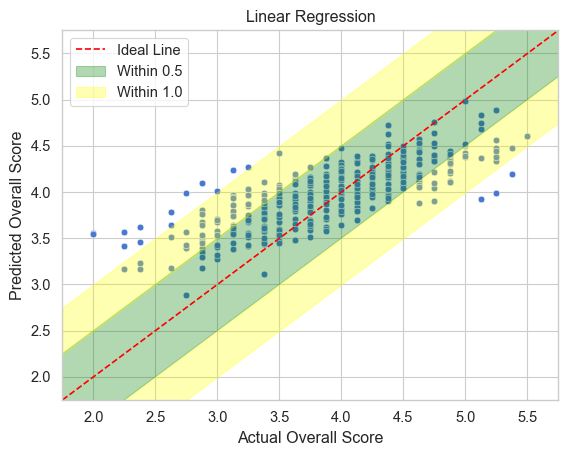

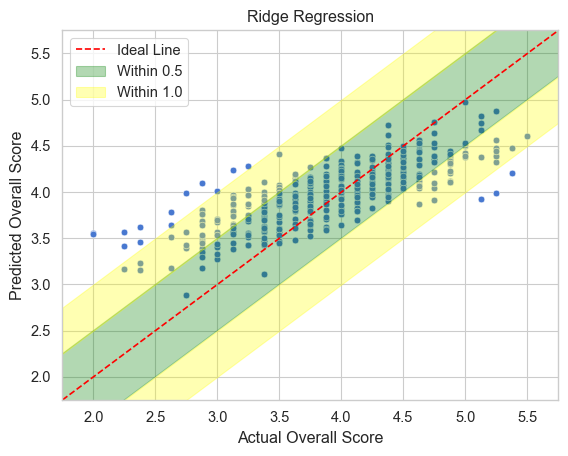

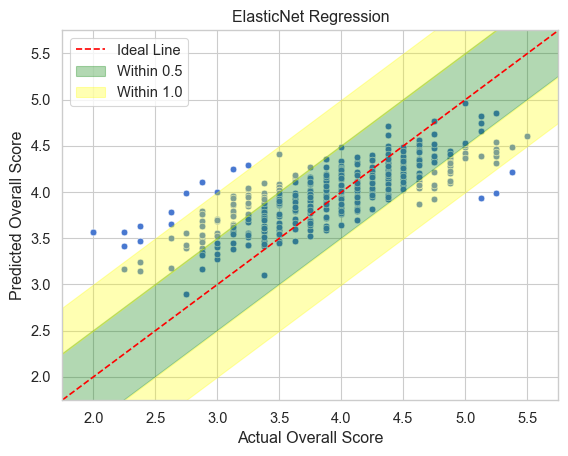

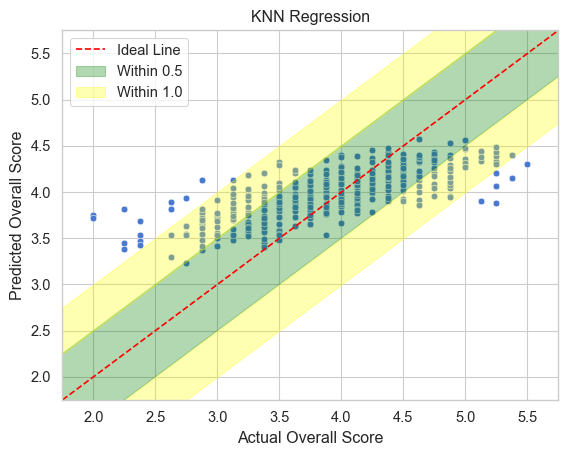

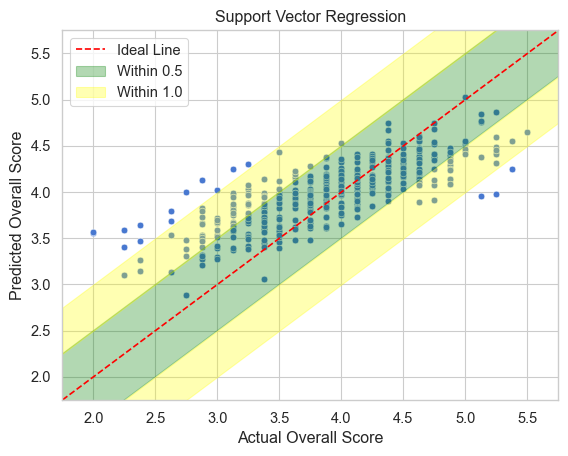

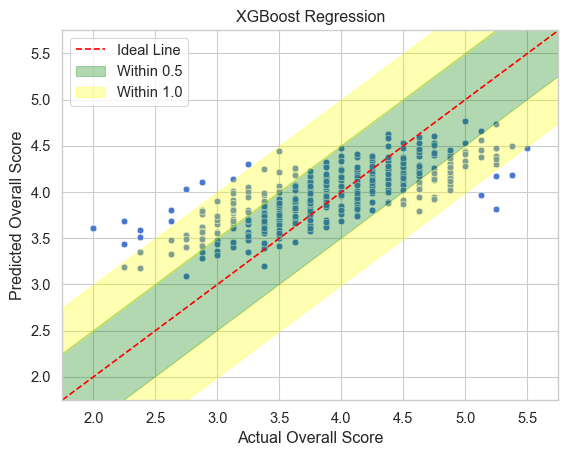

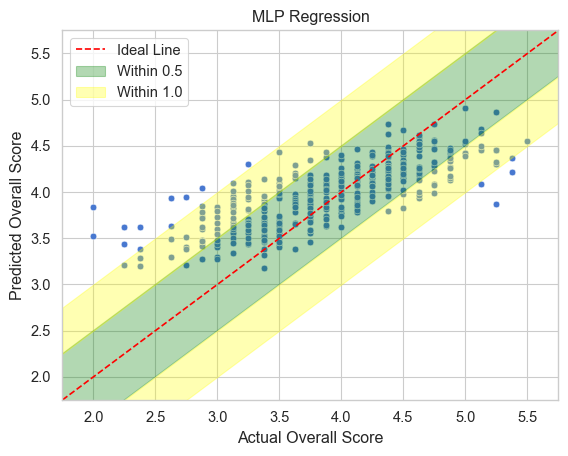

In [7]:
print("Raw score df plots")
for experiment_name, score_df in score_dfs.items():
    plot_score_df(score_df, experiment_name=experiment_name)

Calibrated score df plots


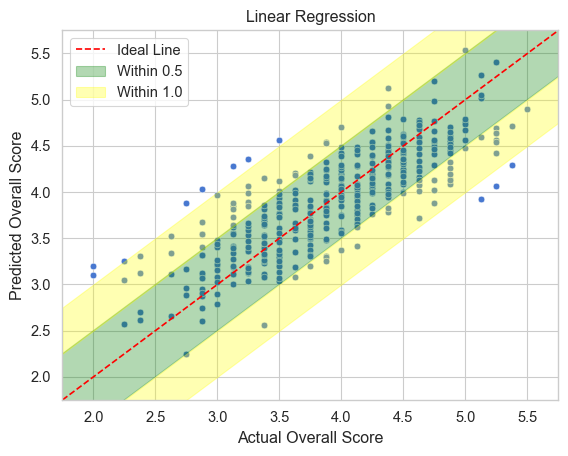

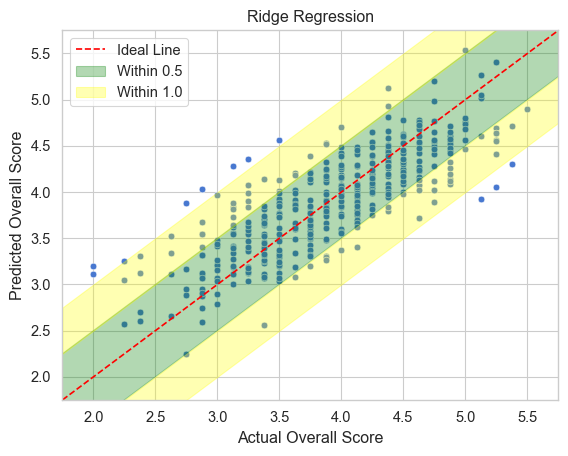

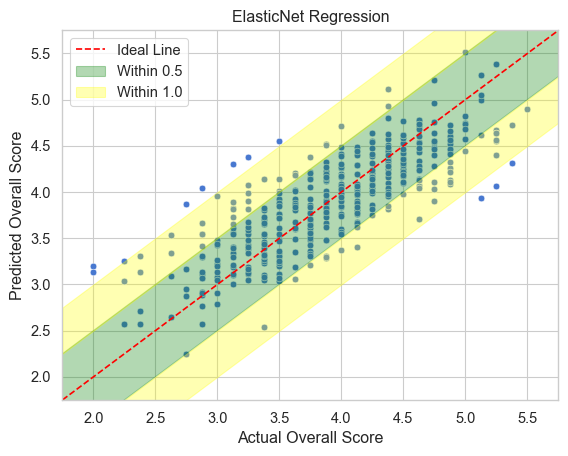

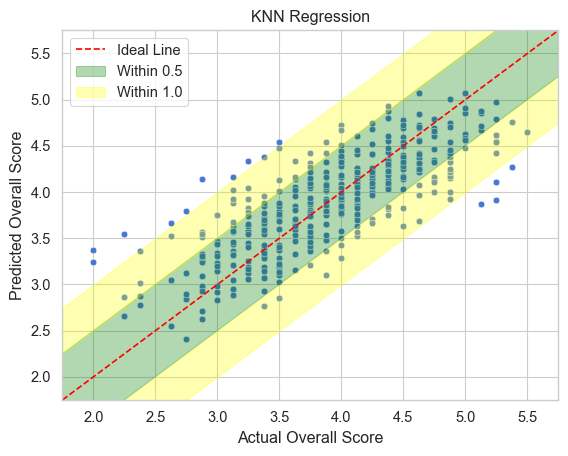

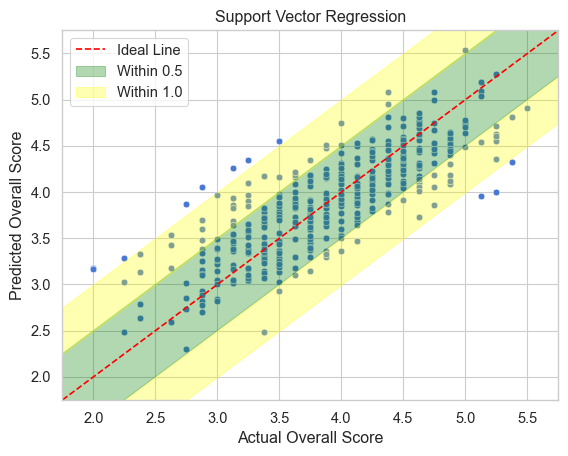

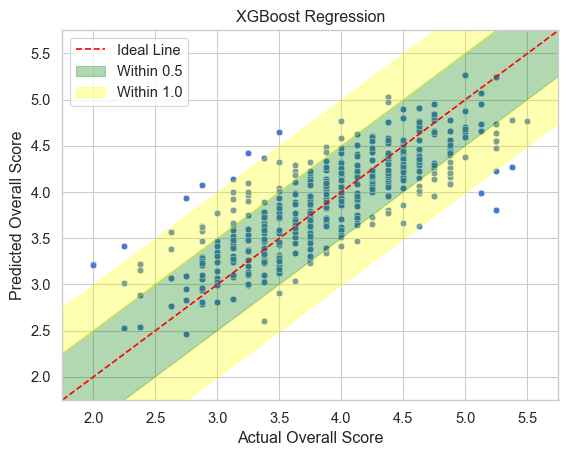

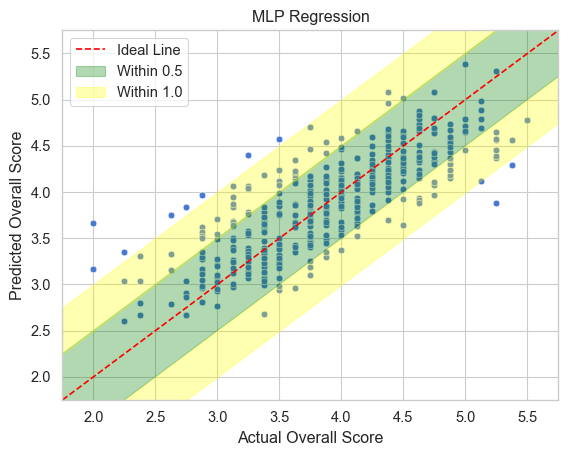

In [8]:
print("Calibrated score df plots")
for experiment_name, calibrated_score_df in calibrated_score_dfs.items():
    plot_score_df(calibrated_score_df, experiment_name=experiment_name)